Read input data files

In [11]:
# Read input samples
import numpy as np
import pandas as pd

#DIR_PREFIX="../TrainingData/PatrickKern/data/"
#training_dirs = ["track1_central", "track1_recovery", "track1_recovery_reverse", "track1_reverse"]
DIR_PREFIX="../TrainingData/Track1/"
training_dirs = ["Center", "Recovery", "Reverse"]

csv_list = []
for one_dir in training_dirs:
    one_sample = pd.read_csv(DIR_PREFIX + one_dir + "/driving_log.csv", header=None, delimiter=',')
    csv_list.append(one_sample)
samples = pd.concat(csv_list)
samples.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']

In [12]:
samples.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000080
1,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000079
2,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000079
3,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000078
4,/home/rajat/work/udacity/sdc/Project3/Training...,/home/rajat/work/udacity/sdc/Project3/Trainin...,/home/rajat/work/udacity/sdc/Project3/Trainin...,0.0,0.0,0.0,0.000078


In [13]:
# Split samples into train and test
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2, shuffle=True)
print(train_samples.size)
print(validation_samples.size)

52010
13006


In [14]:
# Constants
BATCH_SIZE=32

# Input image dimensions
height, width, channel = (160, 320, 3)

In [15]:
import sklearn
from PIL import Image
from sklearn.utils import shuffle

# Generator to get random batch of samples
def generator(samples, batch_size=BATCH_SIZE):
    n_samples = samples.shape[0]
    while True:
        shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            assert(batch_samples.shape[0] > 0)
            images = []
            angles = []
            for idx, one_sample in batch_samples.iterrows():
                angle = float(one_sample['Steering Angle'])
                # Skip images mostly steering straight with 70% probability
                if (abs(angle) < 0.1) and (np.random.randint(0, 10) < 7):
                    continue

                for camera_loc,correction in zip(['Center Image', 'Left Image', 'Right Image'],
                                                 [0.0, 0.25, -0.25]):
                    dir_splits = one_sample[camera_loc].split('/')
                    img_file = DIR_PREFIX + dir_splits[-3] + '/IMG/' + dir_splits[-1]
                    cam_img = np.asarray(Image.open(img_file))
                    assert(cam_img.shape == (height, width, channel))
                    corrected_angle = angle + correction
                    images.append(cam_img)
                    angles.append(corrected_angle)
                    # Flip image and append
                    flipped_img = np.fliplr(cam_img)
                    flipped_angle = -corrected_angle;
                    images.append(flipped_img)
                    angles.append(flipped_angle)

            if len(images) == 0:
                continue

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

In [16]:
# Model Definition
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Lambda, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K
from keras.backend import tf as ktf

sess = ktf.Session(config=ktf.ConfigProto(intra_op_parallelism_threads=8))
K.set_session(sess)
K.set_image_data_format('channels_last')

def resize_image(image):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(image, (64, 64))

my_model = Sequential()
my_model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(height, width, channel)))
my_model.add(Cropping2D(cropping=((70, 25), (0, 0))))
my_model.add(Lambda(resize_image, input_shape=(height, width, channel), output_shape=(64, 64, channel)))
my_model.add(Conv2D(24, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(36, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(48, kernel_size=5, strides=2, activation='elu'))
my_model.add(Conv2D(64, kernel_size=3, activation='elu'))
my_model.add(Conv2D(64, kernel_size=3, activation='elu'))
my_model.add(Flatten())
my_model.add(Dense(100))
my_model.add(Dropout(0.5))
my_model.add(Dense(50))
my_model.add(Dropout(0.5))
my_model.add(Dense(10))
my_model.add(Dropout(0.5))
my_model.add(Dense(1))
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          27712     
__________

In [17]:
# Train the model now
my_model.compile(loss='mse', optimizer='adam')
train_steps = (train_samples.size + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (validation_samples.size + BATCH_SIZE - 1) // BATCH_SIZE
#train_steps = 100
#validation_steps = 10
history_obj = my_model.fit_generator(generator=train_generator, steps_per_epoch=train_steps, epochs=5,
                                     validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/5
1626/1626 [==============================] - 904s 556ms/step - loss: 0.1948 - val_loss: 0.1162
Epoch 2/5
1626/1626 [==============================] - 1114s 685ms/step - loss: 0.1354 - val_loss: 0.0955
Epoch 3/5
1626/1626 [==============================] - 855s 526ms/step - loss: 0.1226 - val_loss: 0.0968
Epoch 4/5
1626/1626 [==============================] - 727s 447ms/step - loss: 0.1152 - val_loss: 0.0899
Epoch 5/5
1626/1626 [==============================] - 770s 474ms/step - loss: 0.1074 - val_loss: 0.0877


<built-in method keys of dict object at 0x7f60758402d0>


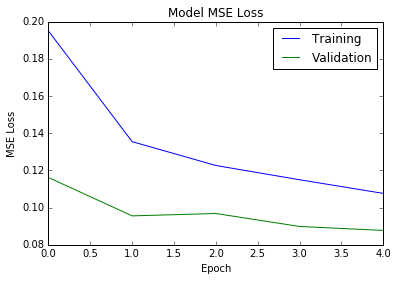

In [18]:
import matplotlib.pyplot as plt

print(history_obj.history.keys)

plt.plot(history_obj.history['loss'])
plt.plot(history_obj.history['val_loss'])
plt.title('Model MSE Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [19]:
my_model.save('my_model.h5')

In [20]:
# Try reloading the model and re-evaluate loss on validation data set
del my_model
from keras.models import load_model
my_model = load_model('my_model.h5')
my_model.evaluate_generator(generator=validation_generator, steps=validation_steps)

0.086543665398688366